In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [12]:
data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
#Data preprocessing

need_clean = []
for x in list(data.columns):
    if True in list(data[x].isna()):
        need_clean.append(x)   #only have missing values in bmi
        

data["bmi"]=data["bmi"].fillna(np.mean(data["bmi"]))


need_clean = []
for x in list(data.columns):
    if True in list(data[x].isna()):
        need_clean.append(x)   #we have now gotten rid of Nans
        
        

        

Stroke fraction is  4.87279843444227 %


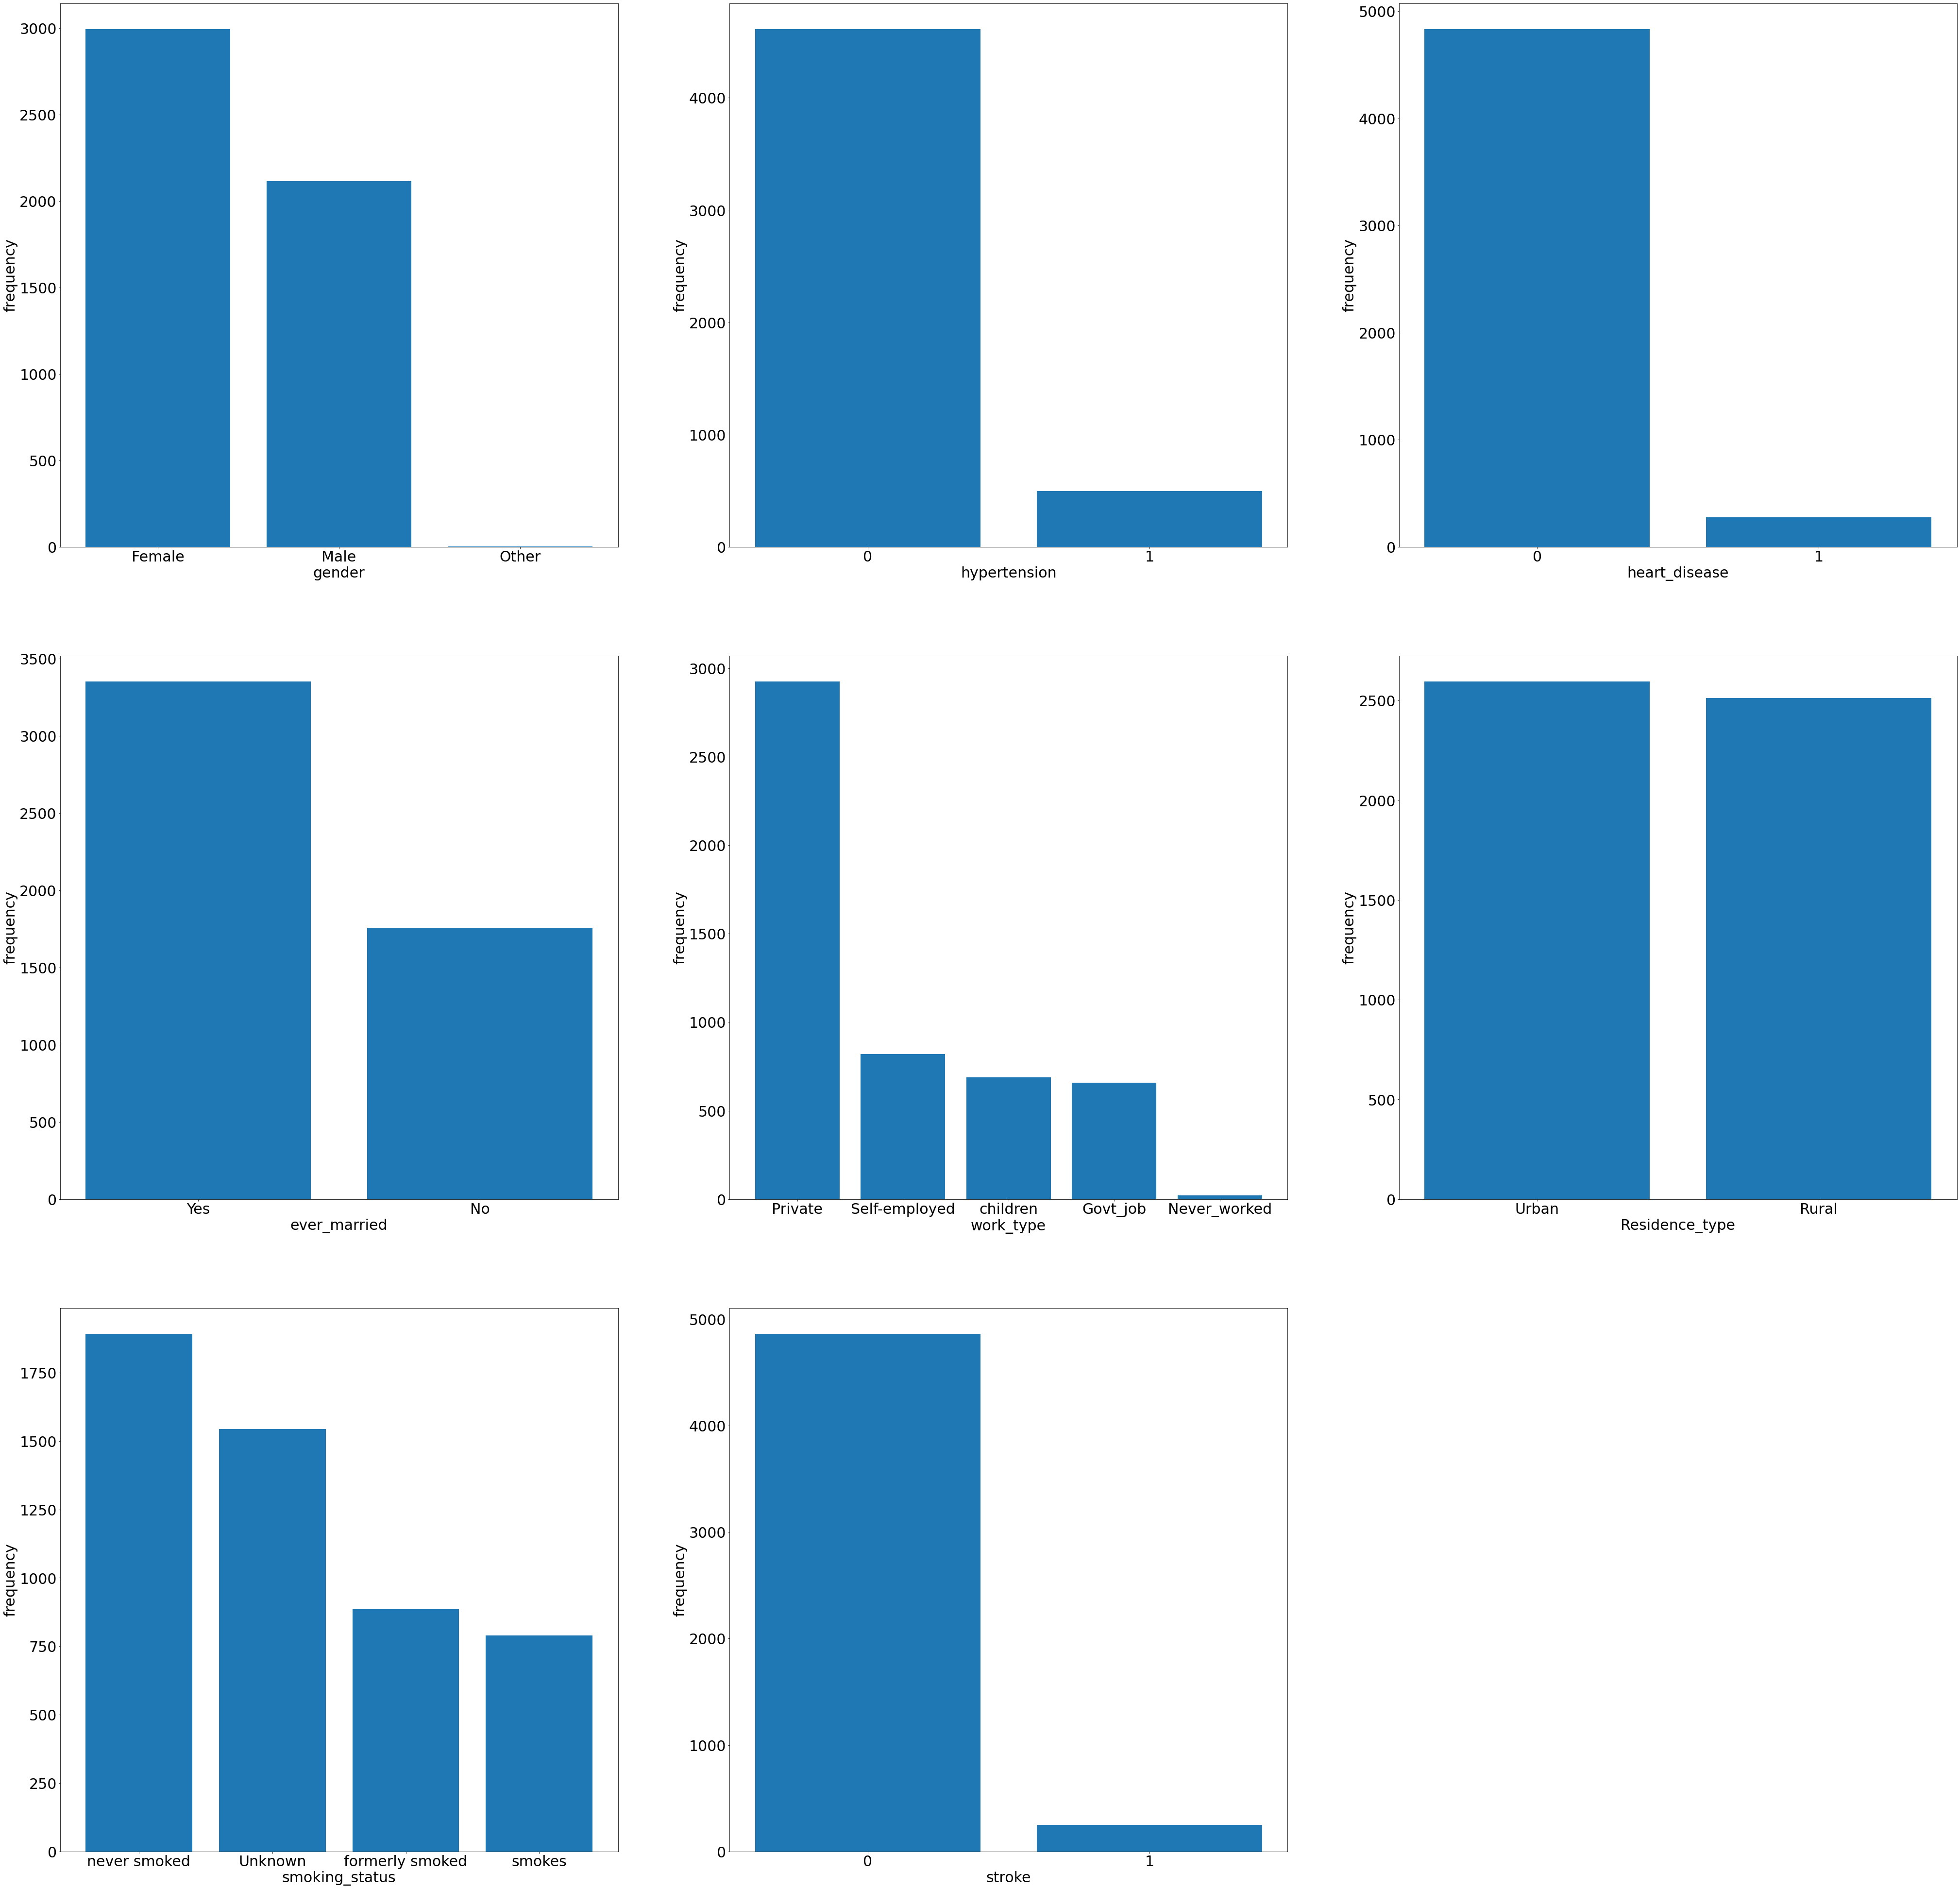

In [14]:
##### explore the training data
import matplotlib.pyplot as plt
import matplotlib
cat_list =['gender','hypertension','heart_disease','ever_married','work_type', 'Residence_type','smoking_status','stroke']

# grouped bar chart
plt.figure(figsize = (70,70))
for i in range(0, len(cat_list)):
  
    primary_cat = cat_list[i]
    plt.subplot (3,3,i+1)
    chart = plt.bar(x = np.arange(0,len(data[primary_cat].unique())),
    height = data[primary_cat].value_counts())
    plt.xlabel(primary_cat)
    plt.ylabel("frequency")
    plt.xticks(ticks = np.arange(0,len(data[primary_cat].unique())), labels=data[primary_cat].value_counts().index.to_list())
   
matplotlib.rcParams.update({'font.size': 45})

#the data is clearly unbalanced, majority of class labels are 0's
balance_ratio =sum(data["stroke"])/len(data)

print("Stroke fraction is ",balance_ratio*100,"%")

#The stroke fraction is very low, need to upsample the class with stroke positives in order to achieve class balance.

3


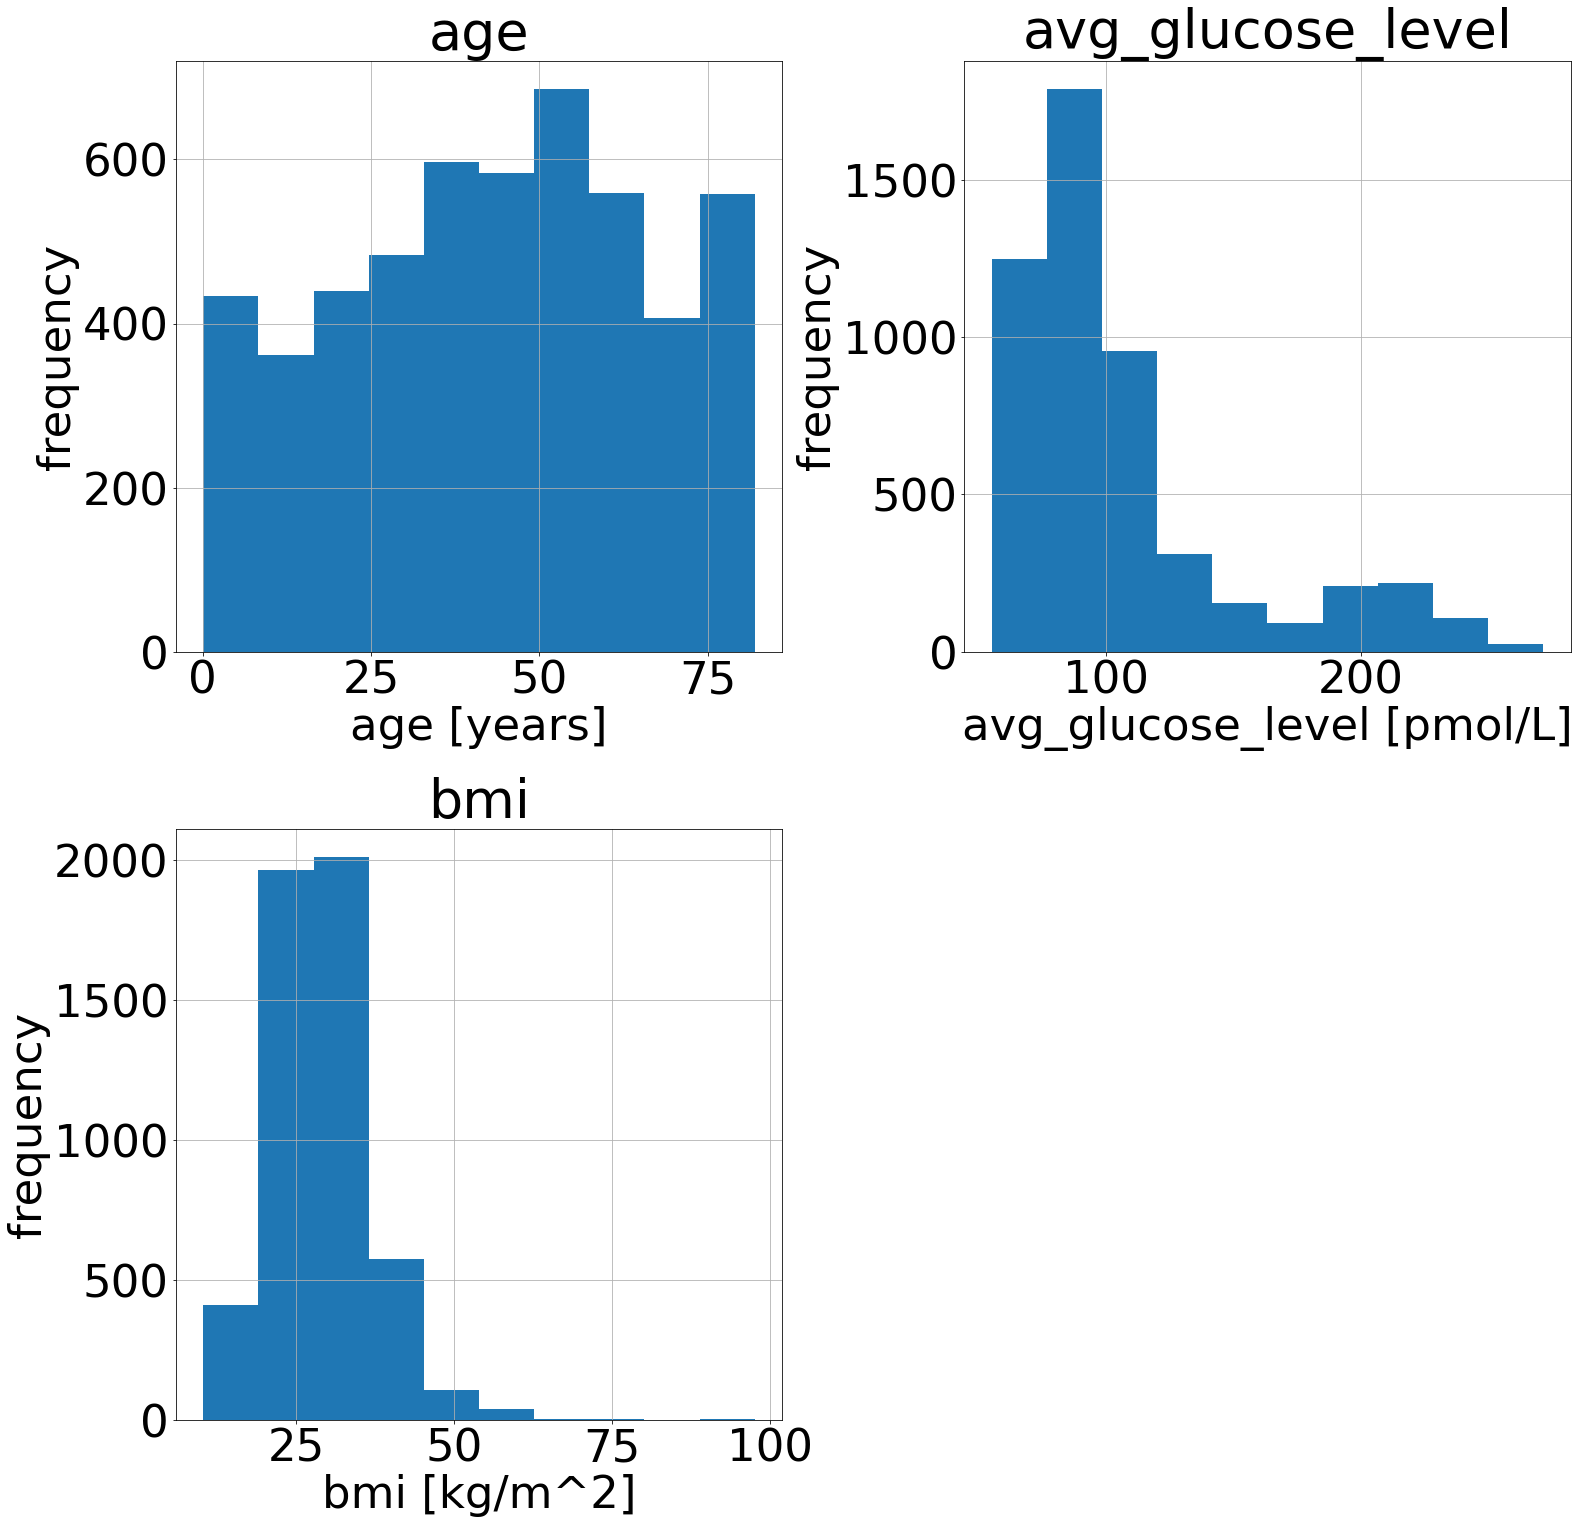

In [15]:
cat_list =['age','avg_glucose_level','bmi']
xlabels = ['age [years]','avg_glucose_level [pmol/L]','bmi [kg/m^2]']

hist= data[cat_list].hist(figsize= (25,25))
i=0
for ax in hist.flatten():
    try:
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel('frequency')
        i+=1

    except:
        print(i)


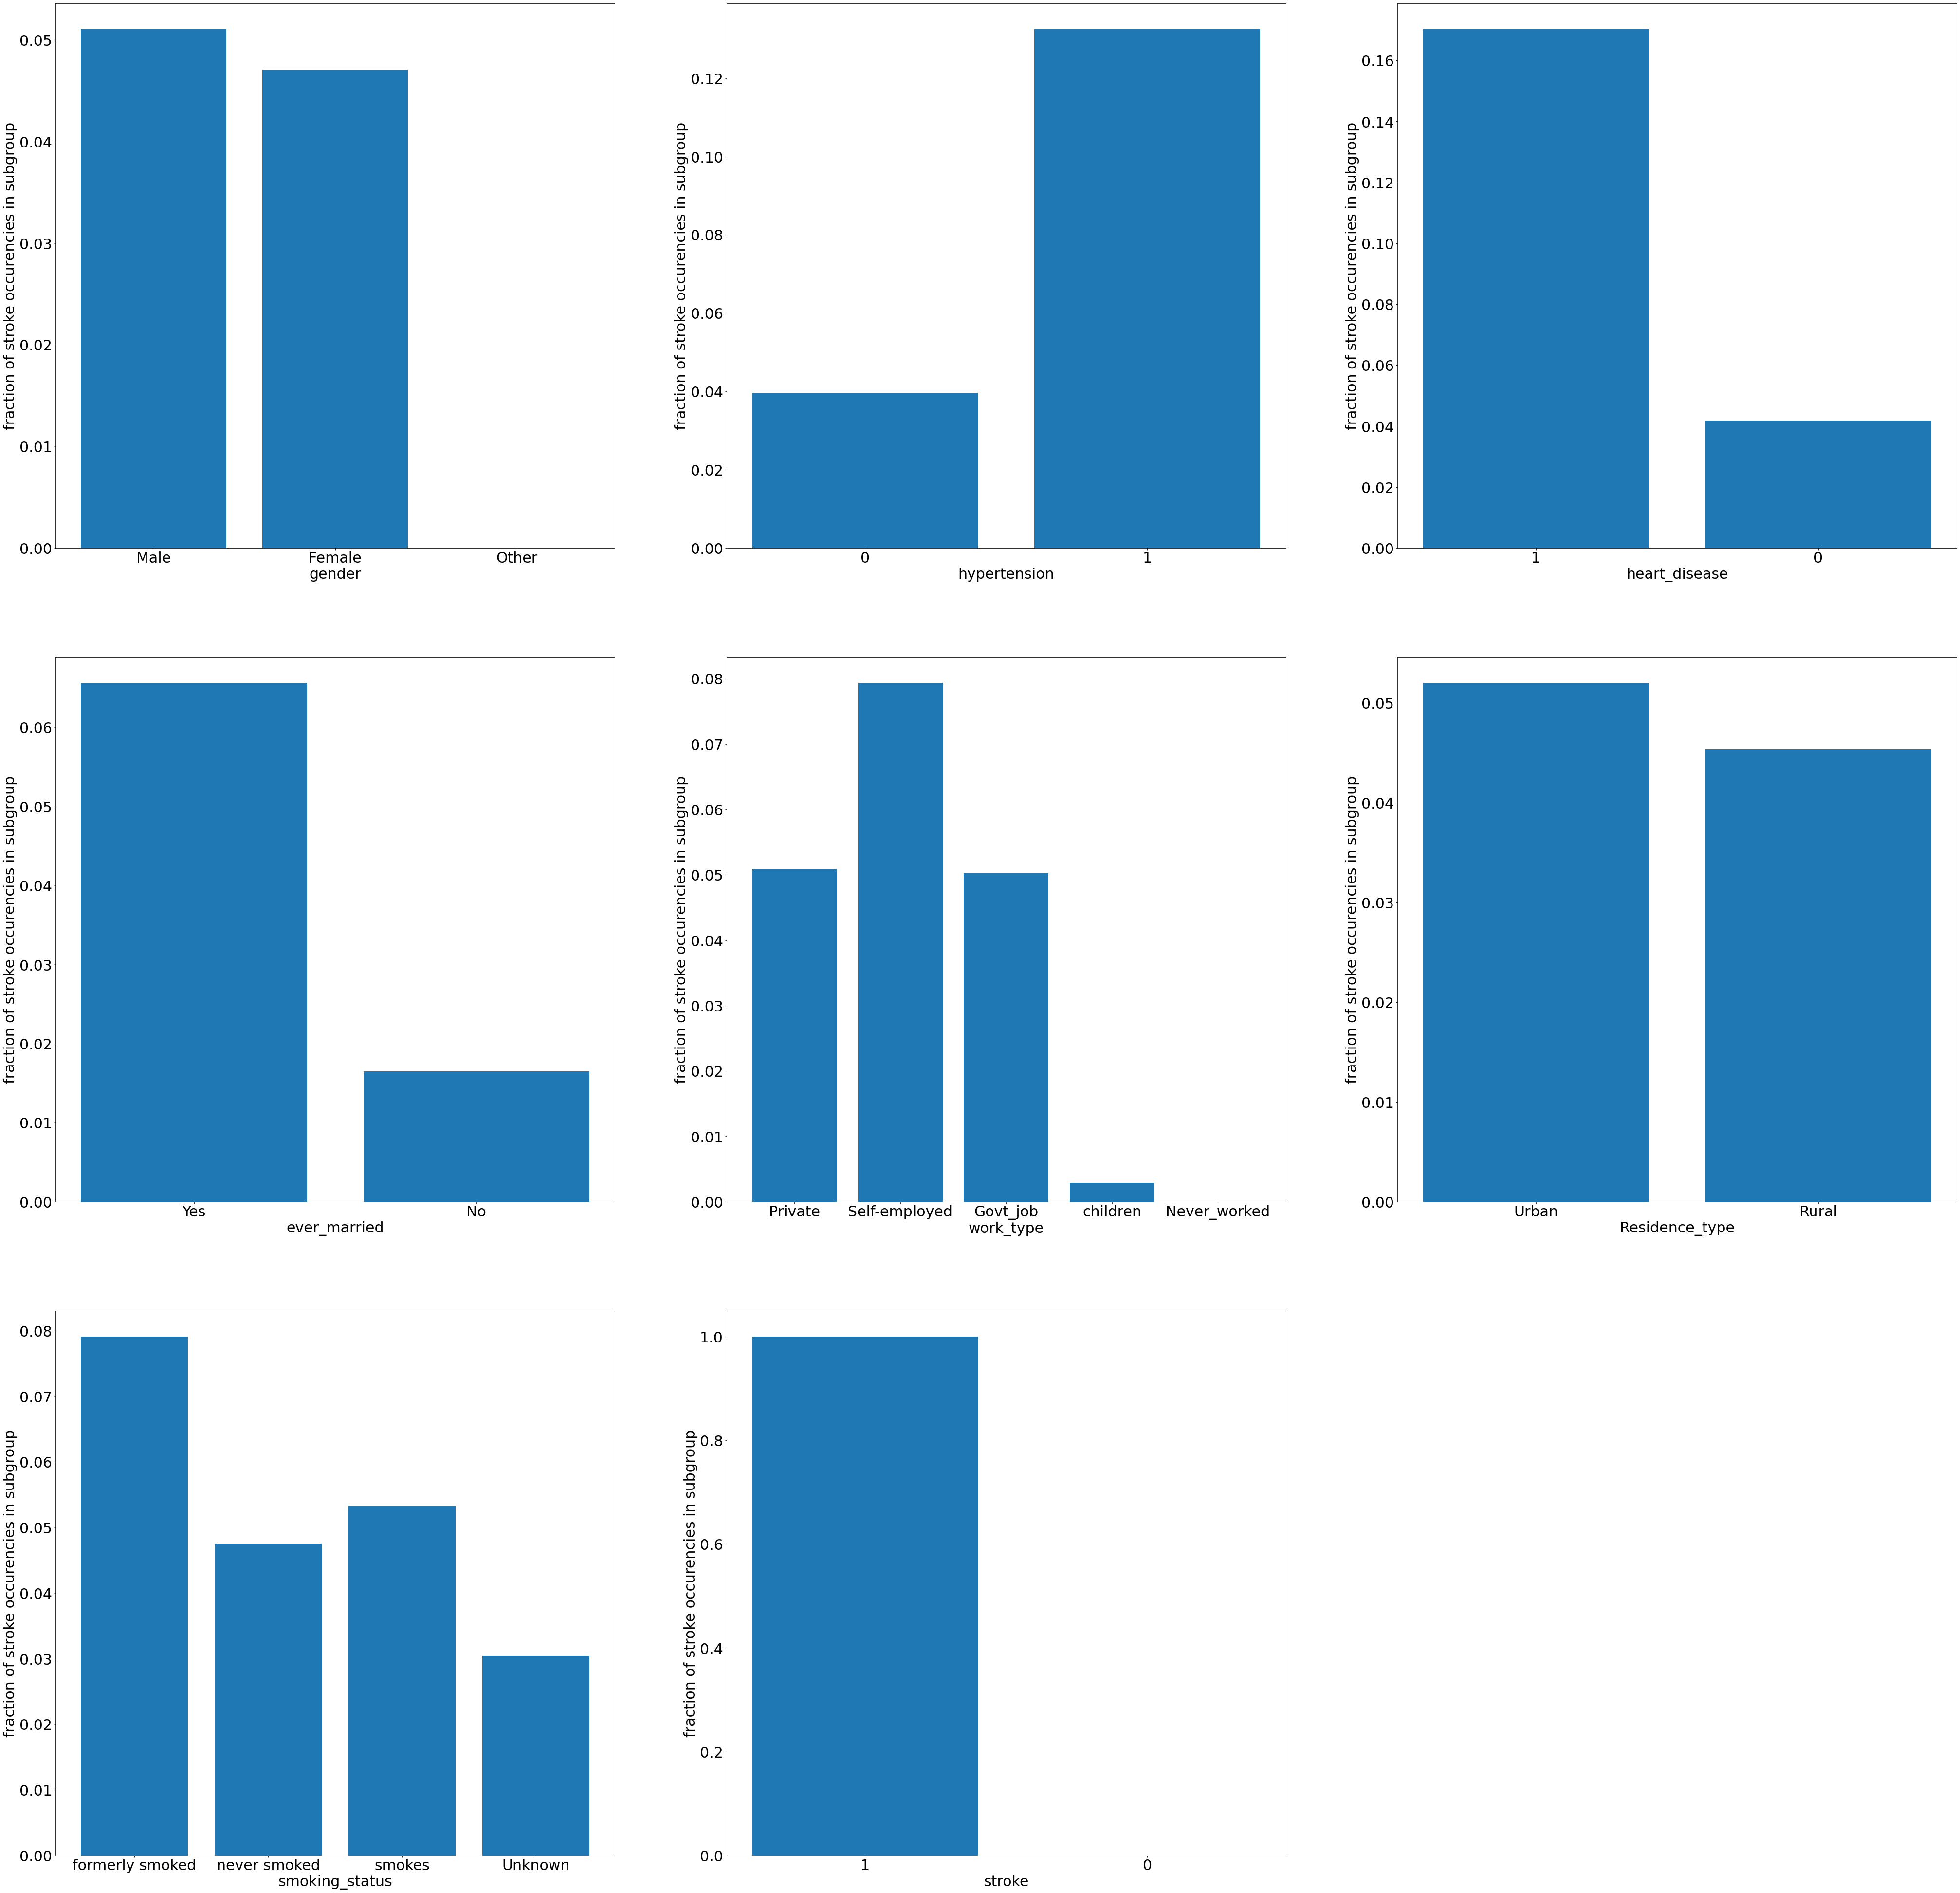

In [16]:
import matplotlib
import matplotlib.pyplot as plt
#compare relative contributions of stroke risk by incorporating percentage of people within each category that have had stroke (eg percentage of government workers that have had stroke to percentage of self employed who had stroke)

#explore relationship between categorical variables and stroke events counting how many occurances of stroke there are amongst different categories presented

cat_list =['gender','hypertension','heart_disease','ever_married','work_type', 'Residence_type','smoking_status','stroke']
# grouped bar chart
plt.figure(figsize = (70,70))
matplotlib.rcParams.update({'font.size': 30})
for i in range(0, len(cat_list)):
    combined = []
    normalisation =[]
    primary_cat = cat_list[i]
    for j in range(0, len(data[primary_cat].unique())):
        secondary_cat = 'stroke'
        primary_sub_cat = data[primary_cat].unique()
        combined.append(sum((data[primary_cat]==primary_sub_cat[j]) & (data[secondary_cat] == 1)) )
        normalisation.append(sum(sum([data[primary_cat].values==primary_sub_cat[j]])))
    plt.subplot (3,3,i+1)
    chart = plt.bar(x = np.arange(0,len(data[primary_cat].unique())),
    height = np.divide(combined, normalisation))
    plt.xlabel(primary_cat)
    plt.ylabel("fraction of stroke occurencies in subgroup")
    plt.xticks(ticks = np.arange(0,len(data[primary_cat].unique())), labels=data[primary_cat].unique())
    

In [17]:
#Convert categorical vars to numbers by using a Label Encoder

from sklearn.preprocessing import LabelEncoder
cat_list_names =['gender','ever_married','work_type', 'Residence_type','smoking_status','stroke']
ids_categorical_columns = []
i=0
for x in data.columns:
    if type(data[x][1]) == str:
        ids_categorical_columns.append(i)
        
        encoderLabel= LabelEncoder()
        encoderLabel.fit(data.iloc[:,i].values.reshape(-1,1))
        data[x]=encoderLabel.transform(data.iloc[:,i].values.reshape(-1,1))
    i+=1




/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [18]:
#upsample the under-represented class
from imblearn.over_sampling import SMOTE

upsampler = SMOTE()


X, y = upsampler.fit_resample(data[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi','ever_married','Residence_type','smoking_status']], data['stroke'])
upsampled_df = X.assign(stroke = y)

In [19]:
upsampled_df["stroke"].value_counts()

0    4861
1    4861
Name: stroke, dtype: int64

In [20]:
#Separate train test data with stratified separation, meaning we preserve class balance within training and test sets


from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

shuffle = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=10)
data_train= pd.DataFrame()
data_test = pd.DataFrame()

for train_ids,test_ids in shuffle.split(upsampled_df,upsampled_df["stroke"]):
    data_train = upsampled_df.loc[train_ids]
    data_test = upsampled_df.loc[test_ids]
    
    
    


work_type           -0.032316
id                   0.006388
gender               0.008929
Residence_type       0.015458
smoking_status       0.028123
bmi                  0.038947
ever_married         0.108340
hypertension         0.127904
avg_glucose_level    0.131945
heart_disease        0.134914
age                  0.245257
stroke               1.000000
Name: stroke, dtype: float64

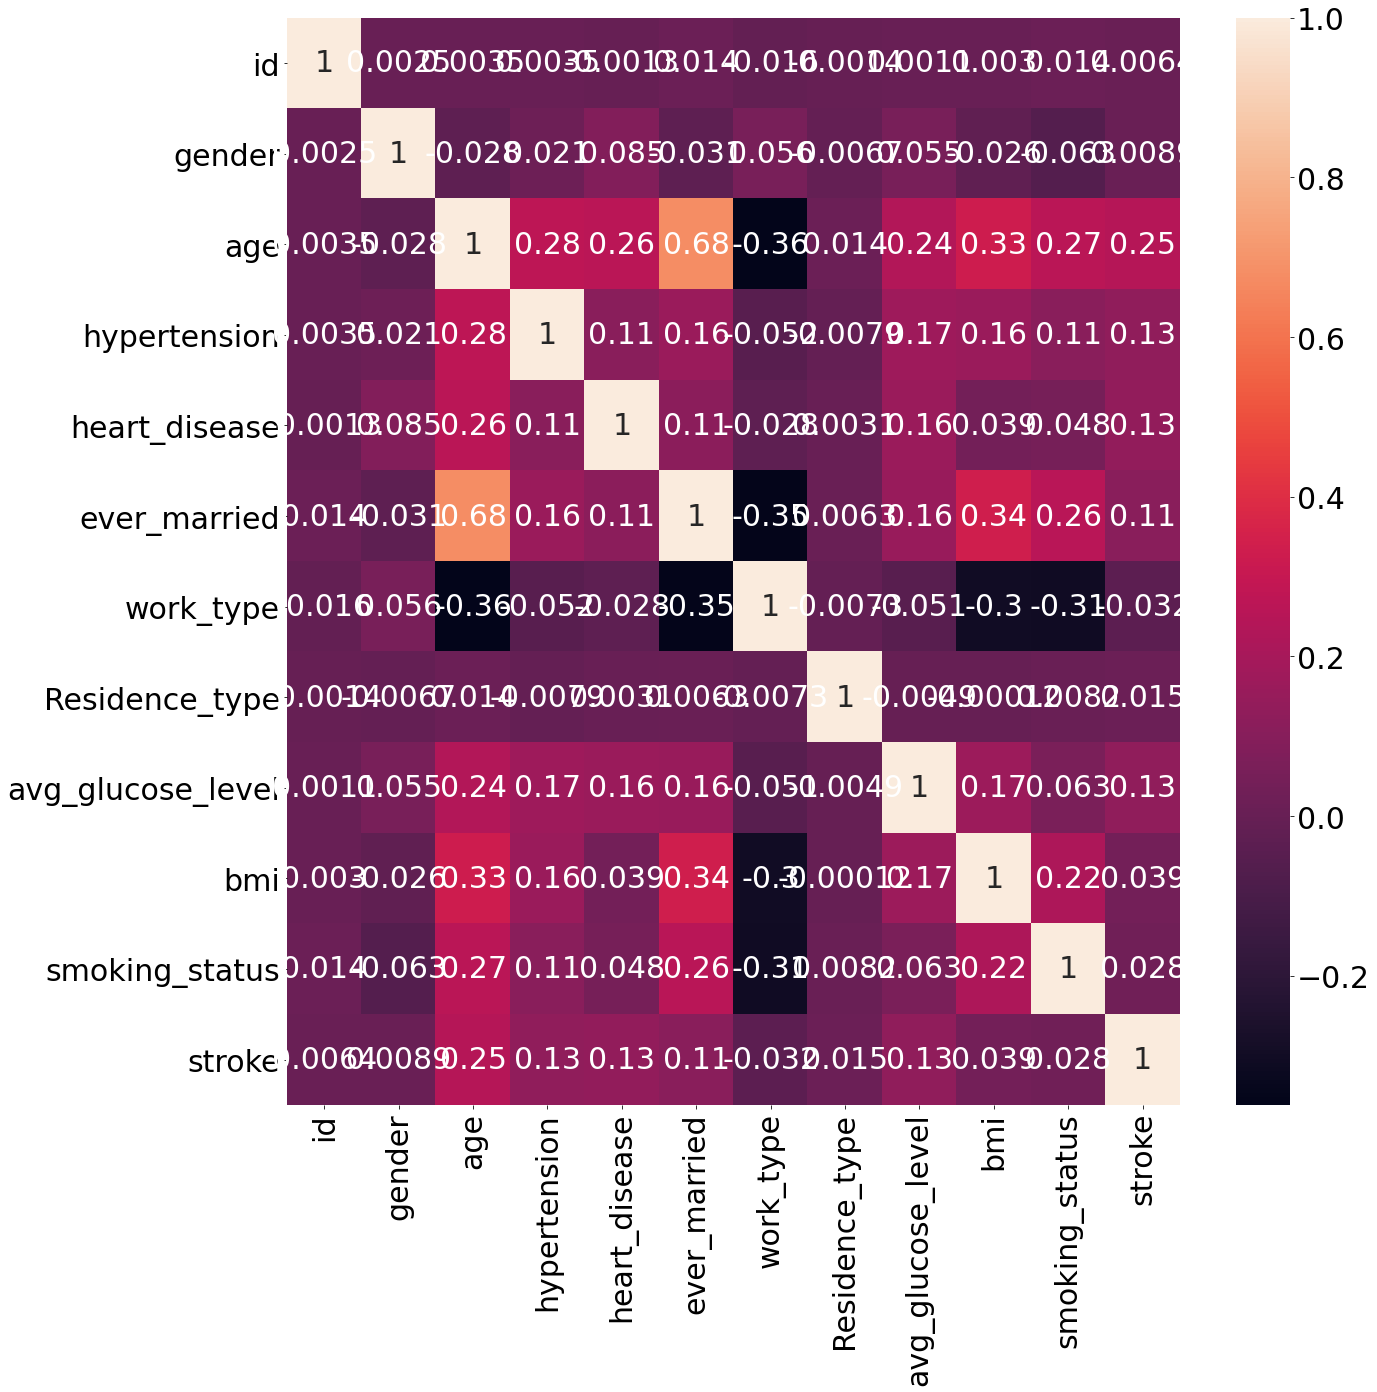

In [21]:
#check correlations between variables and what features the stroke variable correlates with
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

corrs = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrs,annot=True)
corrs["stroke"].sort_values(ascending=True)



A quick analysis suggests that the categorical variables hypertension, heart disease, ever married, work type and smoking status are very predictive of stroke. The other variables such as gender and residence type have very minor influence on the stroke outcomes (and may even be dropped).

In [41]:
#now train a few models and see which is most predictive
#assume features are uncorrelated and try with linear regression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
#plot the confusion matrix for the classifier at hand
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# perform K-fold cross validation 

cross_val = KFold(n_splits = 2,shuffle=False)


accuracy=[]
train_accuracy = []
f1=[[],[]]
f1_ridge = []
confusion_matrix_scores = [[],[]]
num_est =[]
max_depth=[]
for n_est in np.arange(10,300,50):
    i=0
    data_train_val, data_test_val=train_test_split(data_train,test_size=0.2,random_state=42)
    RFC=  RandomForestClassifier(max_depth=60,n_estimators = n_est,class_weight = {0:1,1:1})
    #data_train_val,data_val_val = data_train.iloc[train_ids], data_train.iloc[val_ids]
    X_train = data_train_val.iloc[:,:-1]
    y_train = data_train_val.iloc[:,-1]
    X_val = data_test_val.iloc[:,:-1]
    y_val = data_test_val.iloc[:,-1]

    RFC.fit(X_train.values,y_train.values)
    yhat_RFC = RFC.predict(X_val.values)
    confusion_matrix_scores[i].append(confusion_matrix(yhat_RFC,y_val))

    accuracy.append(sum(abs(yhat_RFC- y_val)))
    train_accuracy.append(sum(abs(y_train.values- RFC.predict(X_train.values))))
    f1.append(f1_score(y_val,yhat_RFC))
    num_est.append(n_est)
    i+=1

In [ ]:
#now train a few models and see which is most predictive
#assume features are uncorrelated and try with linear regression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
#plot the confusion matrix for the classifier at hand
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# perform K-fold cross validation 

cross_val = KFold(n_splits = 2,shuffle=False)


accuracy=[]
train_accuracy = []
f1=[[],[]]
confusion_matrix_scores = [[],[]]
num_est =[]
max_depth=[]
for n_est in np.arange(10,400,50):
    i=0
    data_train_val, data_test_val=train_test_split(data_train,test_size=0.2,random_state=42)
    RFC=  RandomForestClassifier(max_depth=20,n_estimators = n_est,class_weight = {0:1,1:1})
    #data_train_val,data_val_val = data_train.iloc[train_ids], data_train.iloc[val_ids]
    X_train = data_train_val.iloc[:,:-1]
    y_train = data_train_val.iloc[:,-1]
    X_val = data_test_val.iloc[:,:-1]
    y_val = data_test_val.iloc[:,-1]


    RFC.fit(X_train.values,y_train.values)
    yhat_RFC = RFC.predict(X_val.values)
    confusion_matrix_scores[i].append(confusion_matrix(yhat_RFC,y_val))

    accuracy.append(sum(abs(yhat_RFC- y_val)))
    train_accuracy.append(sum(abs(y_train.values- RFC.predict(X_train.values))))
    f1.append(f1_score(y_val,yhat_RFC))
    num_est.append(n_est)
    i+=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  after removing the cwd from sys.path.


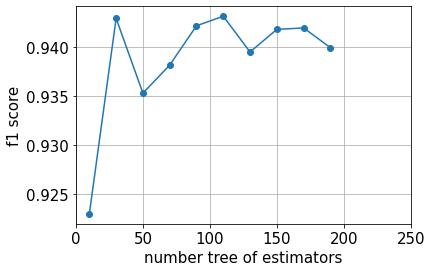

In [60]:
plt.plot(num_est,f1[2:],'o-')
plt.xlabel("number tree of estimators")
plt.ylabel("f1 score")
plt.xticks(np.arange(0,400,50),FontSize=15)
plt.grid()

In [54]:
#now train a few models and see which is most predictive
#assume features are uncorrelated and try with linear regression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
#plot the confusion matrix for the classifier at hand
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# perform K-fold cross validation 

cross_val = KFold(n_splits = 2,shuffle=False)


accuracy=[]
train_accuracy = []
f1=[[],[]]
confusion_matrix_scores = [[],[]]
num_est =[]
max_depth=[]
for mx_depth in np.arange(10,120,10):
    i=0
    data_train_val, data_test_val=train_test_split(data_train,test_size=0.2,random_state=42)
    RFC=  RandomForestClassifier(max_depth=mx_depth,n_estimators = 160,class_weight = {0:1,1:1})
    #data_train_val,data_val_val = data_train.iloc[train_ids], data_train.iloc[val_ids]
    X_train = data_train_val.iloc[:,:-1]
    y_train = data_train_val.iloc[:,-1]
    X_val = data_test_val.iloc[:,:-1]
    y_val = data_test_val.iloc[:,-1]


    RFC.fit(X_train.values,y_train.values)
    yhat_RFC = RFC.predict(X_val.values)
    confusion_matrix_scores[i].append(confusion_matrix(yhat_RFC,y_val))

    accuracy.append(sum(abs(yhat_RFC- y_val)))
    train_accuracy.append(sum(abs(y_train.values- RFC.predict(X_train.values))))
    f1.append(f1_score(y_val,yhat_RFC))
    max_depth.append(mx_depth)
    i+=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  after removing the cwd from sys.path.


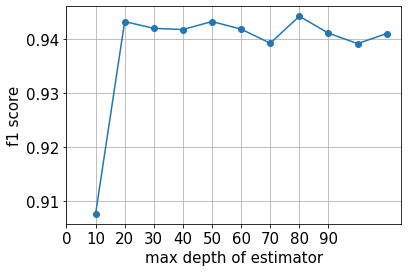

In [48]:
plt.plot(max_depth,f1[2:],'o-')
plt.xlabel("max depth of estimator")
plt.ylabel("f1 score")
plt.xticks(np.arange(0,100,10),FontSize=15)
plt.grid()

In [49]:
#k-fold cross validation for model
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
# perform K-fold cross validation 

cross_val = KFold(n_splits = 10,shuffle=False)

accuracy=[]
train_accuracy = []
crossval_f1=[]
for train,test in cross_val.split(data_train):
    RFC=  RandomForestClassifier(max_depth=20,n_estimators = 160,class_weight = {0:1,1:1})
    X_train = data_train.iloc[train,:-1]
    y_train = data_train.iloc[train,-1]
    X_val = data_train.iloc[test,:-1]
    y_val = data_train.iloc[test,-1]


    RFC.fit(X_train.values,y_train.values)
    yhat_RFC = RFC.predict(X_val.values)

    accuracy.append(sum(abs(yhat_RFC- y_val)))
    train_accuracy.append(sum(abs(y_train.values- RFC.predict(X_train.values))))
    crossval_f1.append(f1_score(y_val,yhat_RFC))
    i+=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


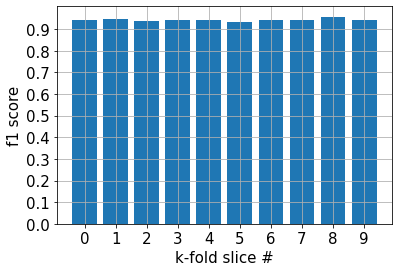

In [50]:
plt.bar(np.arange(0,len(crossval_f1)),crossval_f1)
plt.xlabel("k-fold slice #")
plt.ylabel("f1 score")
plt.xticks(np.arange(0,len(crossval_f1)),fontsize=15)
plt.yticks(np.arange(0,1,0.1),FontSize=15)
plt.grid()

Test set F1 score:0.9472626820693119


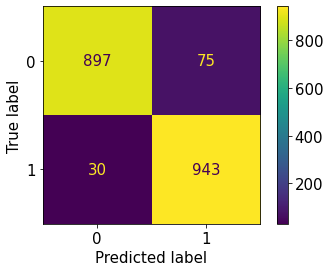

In [51]:
# retrain model on all of the training data and output final test set f1 score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


accuracy=[]
f1_test=[]
RFC=  RandomForestClassifier(max_depth=20,n_estimators = 160,class_weight = {0:1,1:1})
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]


RFC.fit(X_train.values,y_train.values)
yhat_RFC = RFC.predict(X_test.values)

accuracy.append(sum(abs(yhat_RFC- y_test)))
f1_test.append(f1_score(y_test,yhat_RFC))
print("Test set F1 score:"+str(f1_test[0]) )

confusion_mat=confusion_matrix(y_test,yhat_RFC)
plot_confusion_matrix(RFC,X_test,y_test)

Text(0, 0.5, 'Feature Importance [dimensionless]')

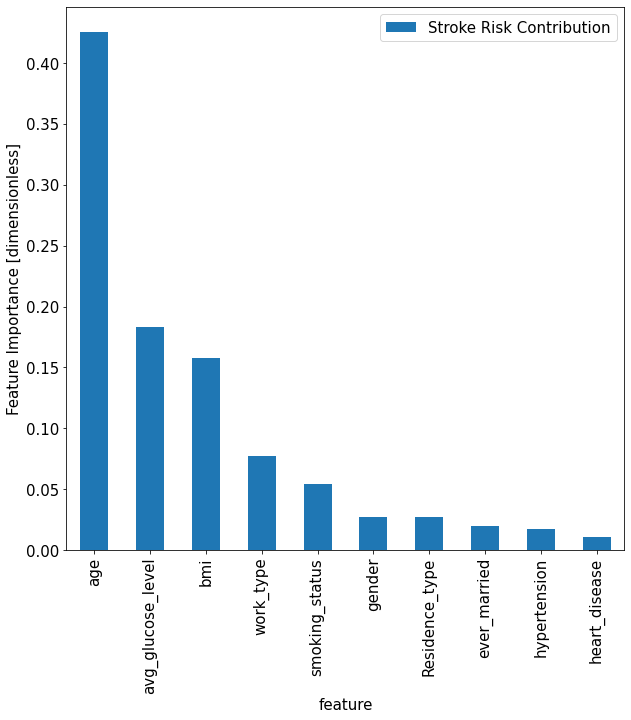

In [34]:
#study the classifier feature importances

weights=RFC.feature_importances_

importances = pd.DataFrame({'feature':X_train.columns,'Stroke Risk Contribution':np.round(RFC.feature_importances_,3)})
importances = importances.sort_values('Stroke Risk Contribution',ascending=False).set_index('feature')

importances.plot.bar(figsize=(10,10))
plt.ylabel("Feature Importance [dimensionless]")


#plt.bar(np.arange(0,len(RFC.feature_importances_)) ,RFC.feature_importances_)
#plt.xticks(ticks = np.arange(0,len(RFC.feature_importances_)),labels=data.columns[1:-1])
